In [3]:
import xarray as xr
import numpy as np
import xoak
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from parcels import ParticleSet
from parcels import JITParticle
from parcels import AdvectionRK4_3D
from parcels import AdvectionRK4
from parcels import Geographic
from datetime import timedelta
import numpy as np
from parcels import FieldSet
from glob import glob

In [24]:
## Set the paths
path1 = ""
mesh_fn = "fesom.mesh.diag.nc"
u_path = 'u.fesom.2005_cut.nc'
v_path = 'v.fesom.2005_cut.nc'
out_path = '' #path to store the particle zarr
out_fn = 'UV_tracking_fesom_2D'

## Set the number of particles
num_particles = 100

## Set the location of the particles 
lon_start = np.random.uniform(2,3,size=(num_particles,)) 
lat_start = np.random.uniform(7.5, 12.5, size=(num_particles,))

## set the tracking time
days = 30
minutes = 10

## record the particles every timestep of
hours=4

In [25]:
ds_mesh = xr.open_dataset(path1+mesh_fn)
#now we define new coords
ds_mesh = ds_mesh.assign_coords(
    nod2=list(range(1, ds_mesh.sizes["nod2"]+1)), 
    elem=list(range(1,ds_mesh.sizes['elem']+1)),
)

#corners
elem_corner_lons = ds_mesh.lon.sel(nod2=ds_mesh.face_nodes)
elem_corner_lats = ds_mesh.lat.sel(nod2=ds_mesh.face_nodes)

max_elem_lon_range = 0.2
tri_overlap=(elem_corner_lons.max('n3') - elem_corner_lons.min('n3')) > max_elem_lon_range

near_channel_width =4
channel_width = 4.5
elem_corner_lons_unglued = xr.where(tri_overlap & (elem_corner_lons > near_channel_width), 
                                   elem_corner_lons - channel_width, elem_corner_lons)


elem_center_lons_unglued = elem_corner_lons_unglued.mean('n3')
elem_center_lats = elem_corner_lats.mean('n3')

elem_center_lons = elem_corner_lons.mean('n3')

## assign coordinates to the mesh
ds_mesh = ds_mesh.assign_coords(
    elem_center_lons=elem_center_lons_unglued,
    elem_center_lats=elem_center_lats,
)
#nearest neighbour interpolation
ds_mesh.xoak.set_index(['elem_center_lats','elem_center_lons'], 'sklearn_geo_balltree')

channel_lon_bds = (0,4.5) # use inmutable objects
channel_lat_bds = (0,18)
number_lon = 2*72 
number_lat = 2*292

w_lon = int(2*51.5)
w_lat = int(2*206)

grid_lon = xr.DataArray(np.linspace(*channel_lon_bds,number_lon), 
                        dims=('grid_lon',))
grid_lat = xr.DataArray(np.linspace(*channel_lat_bds,number_lat),
                        dims=('grid_lat',))

#reorder the lat and lon into a C grid
target_lon, target_lat = xr.broadcast(grid_lon, grid_lat)

#select the grid elements
grid_elems = ds_mesh.xoak.sel(
    elem_center_lats = target_lat,
    elem_center_lons = target_lon,
).elem

grid_elems = grid_elems.assign_coords(
    target_lat = target_lat,
    target_lon = target_lon,
)

grid_elems = grid_elems.assign_coords(
    grid_lat=grid_lat,
    grid_lon=grid_lon,
)

## U and V

In [26]:
ds_u = xr.open_mfdataset(path1+u_path,
                         chunks ={'time':1, 'nz1': 1}).isel(time=slice(0,360),nz1=0)
# first selecting only the surface nz1=0
ds_v = xr.open_mfdataset(path1+v_path,
                         chunks = {'time':1, 'nz1':1}).isel(time=slice(0,360),nz1=0)

/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


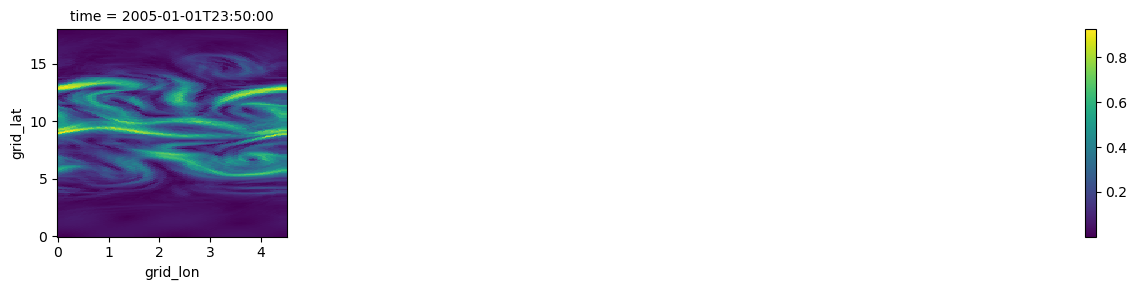

In [27]:
U_grid = ds_u.u.isel(elem=grid_elems - 1).compute() 
V_grid = ds_v.v.isel(elem=grid_elems - 1).compute()

SPD_grid = (U_grid**2 + V_grid**2) **0.5
SPD_grid.isel(time=slice(None,16)).plot(x='grid_lon', 
                                        y='grid_lat', col='time',col_wrap=4)

In [28]:
#create a dataset for the UV
ds_uv_grid= xr.Dataset({
    'U':U_grid,
    "V":V_grid,
})
#ds_uv_grid

## Parcels

In [29]:
from parcels import ParticleSet
from parcels import JITParticle
from parcels import AdvectionRK4
from datetime import timedelta
import numpy as np
from parcels import FieldSet

In [30]:
fieldset = FieldSet.from_xarray_dataset(
    ds_uv_grid.transpose('time','grid_lat','grid_lon'),
    variables={'U':"U", "V":"V"},
    dimensions={'lon':'grid_lon',
                'lat':'grid_lat',
                'time':'time'},
    time_periodic=False,
    allow_time_extrapolation=True,
)


### Adding the Halo

In [31]:
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)
fieldset.U.units = Geographic()

In [32]:
def periodicBC(particle,fielset,time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

In [33]:
pset = ParticleSet.from_list(
    pclass = JITParticle,
    fieldset = fieldset,
    lon=lon_start,
    lat=lat_start,
)

In [34]:
output_file = pset.ParticleFile(name=out_path+out_fn, 
                                outputdt=timedelta(hours=hours))

In [35]:
## Execute particles
pset.execute(
    [AdvectionRK4,periodicBC],
    runtime=timedelta(days=days),
    dt=timedelta(minutes=minutes),
    output_file= output_file
)

INFO: Output files are stored in UV_tracking_fesom_2D.zarr.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2592000.0/2592000.0 [00:03<00:00, 717553.70it/s]


### Make a beutiful plot

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from itertools import zip_longest
from functools import reduce
from operator import add
from pathlib import Path
import tqdm

In [2]:
ds_traj = xr.open_zarr("UV_tracking_fesom_2D.zarr")
ds_traj = ds_traj.compute()
ds_traj

<xarray.Dataset> Size: 362kB
Dimensions:     (trajectory: 100, obs: 180)
Coordinates:
  * obs         (obs) int32 720B 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * trajectory  (trajectory) int64 800B 100 101 102 103 104 ... 196 197 198 199
Data variables:
    lat         (trajectory, obs) float32 72kB 10.99 10.96 10.92 ... 10.13 10.13
    lon         (trajectory, obs) float32 72kB 2.486 2.474 2.465 ... 2.194 2.261
    time        (trajectory, obs) datetime64[ns] 144kB 2005-01-01T23:50:00 .....
    z           (trajectory, obs) float32 72kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4periodicBC
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [3]:
def line_between(start,end):
    """Find the intermediate points on a line from (x0,y0) to (x1,y1).

    Parameters
    ------------
    start: tuple
        Contains x0 and y0
    end: tuple
        Contains x1 and y1

    Returns
    --------
    list
        List of all intermediate points (x,y)

    """
    x0,y0 = start
    x1,y1 = end
    #This extracts the individual coordinates from the start and end tuples.
    N = max(abs(x1 - x0) + 1, abs(y1 - y0) + 1) #calculate the number of steps
    #Calculate the incremental step sizes
    dx = (x1 - x0) / (N - 1) #for stepping in lon or x
    dy = (y1 - y0) / (N - 1) #for stepping in lat or y
    #the steps secure the evenly spaced points between the start and end

    #Generate the intermediate points
    xx = (round(x0 + n * dx) for n in range(N))
    yy = (round(y0 + n * dy) for n in range(N))
    #Combines the x and y coordinates into a list of tuples 
    return list(zip(xx,yy))

#%------ Line in between ---- %
def line_between_sequence(points):
    """ Fill in lines on all segments of points.

    Parameters
    ----------
    points: list
        List of points (x,y).

    Returns
    -------
    list
        List of points(x,y) with all segments filled in.

    """

    segments = [
    line_between(start,end)[:-1]
    for start, end in zip(points[:-1], points[1:])
    ] + [points[-1:], ]
    return reduce(add, segments)

In [4]:
skip_this_step = abs(ds_traj.lon.diff('obs')) > 4.0
ds_traj_nowrap = ds_traj.where(~skip_this_step)

In [5]:
### Unrolling
ad_lon = 0 + 4.5 * (ds_traj.lon.diff('obs') < -4) - 4.5 * (ds_traj.lon.diff('obs') > 4)
lon_unrolled = (ds_traj.lon + ad_lon.cumsum('obs')) #we accumulate the corrections 
##Binning
Nx = 45 #~4.5
Ny = 180 #~18.0

#Each ghost image band corresponds to an increment of 4.5 longitude units.
#Creates ghost images in left and right 
pix_replica_lon = lon_unrolled.min().compute().data[()] //4.5 , lon_unrolled.max().compute().data[()] //4.5 + 1
pix_x_unrolled = np.arange(pix_replica_lon[0] * Nx, pix_replica_lon[1] * Nx).astype(int)

lon_bds = (int(pix_replica_lon[0] *4.5), int(pix_replica_lon[1] * 4.5))
lat_bds = (0,18)
lon_bds_base = (0,4.5)
lon_bds, lat_bds

((0, 13), (0, 18))

In [6]:
dens = np.zeros((Ny,Nx), dtype=int)
## check the error of the tranpositn
for traj in tqdm.tqdm(ds_traj.trajectory.isel(trajectory=slice(None,None,1)).data):
    lon_traj = lon_unrolled.sel(trajectory=traj).compute().data
    lat_traj = ds_traj.lat.sel(trajectory=traj).compute().data
    point_list = list(zip(      
        np.digitize(lat_traj, np.linspace(*lat_bds, Ny)).astype(int) -1,
        np.digitize(lon_traj, np.linspace(*lon_bds, int((pix_replica_lon[1] - pix_replica_lon[0]) * Nx))).astype(int)-1,
    ))

    #drop the duplicates
    point_list = [i for i, j in zip_longest(point_list, point_list[1:]) if i !=j]
    pos,count = np.unique(np.array(line_between_sequence(point_list)), axis=0, return_counts = True)
    #wrap back to Nx and Ny
    pos = pos % [Ny,Nx]
    dens[*pos.T] +=count
    #break

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1052.59it/s]


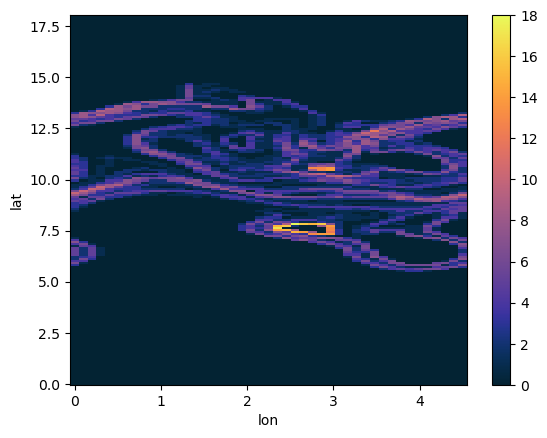

In [7]:
dens_array = xr.DataArray(
    dens,
    dims = ('lat','lon'),
    coords = {
        'lat':np.linspace(*lat_bds, Ny), 
        'lon':np.linspace(*lon_bds_base, Nx), 
    },
)

dens_array.plot.imshow(cmap=cm.thermal)